In [18]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
from radio_beam import Beam

plt.rcParams.update({"text.usetex": True,
                     "font.family": "serif",
                     'xtick.direction': 'in',
                     'ytick.direction': 'in',
                     'xtick.major.size': 6,
                     'ytick.major.size': 6,
                     'xtick.minor.size': 3,
                     'ytick.minor.size': 3})
distance = 300. * u.pc

## Regions to be used
Lets show the integrated intensity maps of the regions.

In [19]:
my_figsize = (6, 4)
file_list_TdV = ['data/NGC1333_13CO_1-0-TdV.fits',
                 'data/NGC1333_SE_C18O-TdV.fits',
                 'data/NGC1333_H13COp_L17-TdV.fits',
                 'data/NGC1333_HNC_L23-TdV.fits',
                 'data/NGC1333_HCN_L21-TdV.fits']
col_pos = [0.6, 0.2, 0.35, 0.025]

xpos_lab1, ypos_lab1 = (0.05, 0.9)
xpos_lab2, ypos_lab2 = (0.05, 0.85)
xpos_lab3, ypos_lab3 = (0.075, 0.875)

beam_pos_13CO = SkyCoord("03h31m20.0s", "31d52m0s", frame='fk5')
scalebar_pos_13CO = SkyCoord("03h27m30.0s", "30d47m30s", frame='fk5')

beam_pos_C18O = SkyCoord("03h29m26.0s", "31d25m45s", frame='fk5')
scalebar_pos_C18O = SkyCoord("03h28m35.0s", "31d11m00s", frame='fk5')

beam_pos_NOEMA = SkyCoord("03h29m23.2s", "31d17m2s", frame='fk5')
scalebar_pos_NOEMA = SkyCoord("03h29m02.5s", "31d11m00s", frame='fk5')


In [20]:
# distance = 300. # pc

def load_cutout(file_in, is_hdu=False):
    if is_hdu==False:
        hdu = fits.open(file_in)[0]
    else:
        hdu = file_in
    # Make the cutout, including the WCS
    cutout = Cutout2D(hdu.data, position=position, size=cutout_size, wcs=WCS(hdu.header))
    hdu.data = cutout.data
    hdu.header.update(cutout.wcs.to_header())
    return hdu

def plot_setup_ngc1333_wcsaxes(ax, hdu, label_col='black', telescope='NOEMA'):
#     , contour_n2hp=False, contour_sio=False):
    if telescope == 'FCRAO':
        beam_pos = beam_pos_13CO
        scalebar_pos = scalebar_pos_13CO
        format_xaxis = 'hh:mm'
        scalebar_length = 1 * u.pc
        scalebar_text="1 pc"
        tick_minor_x = 4
        tick_minor_y = 3
        scalebar_pos_dy = 3*u.arcmin #@0.004*u.deg
    elif telescope == 'JCMT':
        beam_pos = beam_pos_C18O
        scalebar_pos = scalebar_pos_C18O
        format_xaxis = 'hh:mm:ss'
        scalebar_length = 0.2 * u.pc
        scalebar_text="0.2 pc"
        tick_minor_x = 5
        tick_minor_y = 5
        scalebar_pos_dy = 0.75*u.arcmin #@0.004*u.deg
    else:
        beam_pos = beam_pos_NOEMA
        scalebar_pos = scalebar_pos_NOEMA
        format_xaxis = 'hh:mm:ss'
        scalebar_length = 10e3*u.au
        scalebar_text="10,000 au"
        tick_minor_x = 4
        tick_minor_y = 4
        scalebar_pos_dy = 0.004*u.deg
    # ticks
    ra_ax = ax.coords[0] # lon
    dec_ax = ax.coords[1] # lat
    ra_ax.set_major_formatter(format_xaxis)#'hh:mm:ss')
    dec_ax.set_major_formatter('dd:mm')
    ra_ax.display_minor_ticks(True)
    dec_ax.display_minor_ticks(True)
#     ra_ax.set_ticks(spacing=8*15 * u.arcsec, color=label_col)
#     dec_ax.set_ticks(spacing=2 * u.arcmin, color=label_col)
    ra_ax.set_minor_frequency(tick_minor_x)
    dec_ax.set_minor_frequency(tick_minor_y)
    ax.tick_params(which='major', length=6)
    ax.tick_params(which='minor', length=3)
    ax.autoscale(enable=False)
    
#     ax.scatter(ra_yso, dec_yso, marker='*', s=marker_size, c='white', edgecolor='black',
#                  linewidth=1.5, zorder=4, alpha=0.5, transform=ax.get_transform('world'))

#     if contour_n2hp:
#         hdu_n2hp = load_cutout(file_TdV_N2Hp)
#         ax.contour(hdu_n2hp.data, levels=levels_N2Hp, 
#                    transform=ax.get_transform(WCS(hdu_n2hp.header)), 
#                    colors='black', linewidths=1, alpha=0.5)
#     if contour_sio:
#         hdu_sio = load_cutout(file_TdV_SiO)
#         ax.contour(hdu_sio.data, levels=levels_SiO, 
#                    transform=ax.get_transform(WCS(hdu_sio.header)), 
#                    colors='black', linewidths=1, alpha=0.5)
    # Add beamsize
    my_beam = Beam.from_fits_header(hdu.header)
    xcen_pix, ycen_pix  = WCS(hdu.header).world_to_pixel(beam_pos)
    pixscale = np.abs(hdu.header['cdelt1']) * u.deg
    ellipse_artist = my_beam.ellipse_to_plot(xcen_pix, ycen_pix, pixscale)
    ellipse_artist.set_color('black')
    _ = ax.add_artist(ellipse_artist)      
    
    # Scalebar
    length = ( scalebar_length/ (distance)).to(u.deg, u.dimensionless_angles())
    ax.plot([scalebar_pos.ra.deg, (scalebar_pos.ra - length).deg]*u.deg,
        [(scalebar_pos.dec).deg]*2*u.deg,
        'k', transform=ax.get_transform('fk5'), zorder=100, linewidth=1)
    ax.text((scalebar_pos.ra - length / 2).deg, (scalebar_pos.dec - scalebar_pos_dy).deg,
        scalebar_text, color='k', transform=ax.get_transform('fk5'), ha='center')
    #
    ax.set_xlabel(r'Right Ascension (J2000)')
    ax.set_ylabel(r'Declination (J2000)')
    return #fig_i

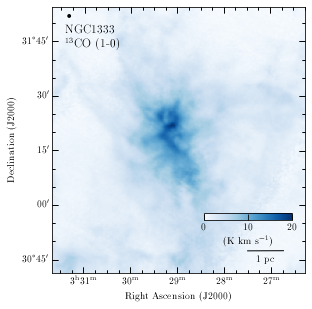

In [21]:
text_color = 'black'

hdu = fits.open(file_list_TdV[0])[0]
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='Blues').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, vmin=0.0, vmax=20.0, cmap=cmap, origin='lower')
ax.invert_xaxis()
ax.invert_yaxis()

plot_setup_ngc1333_wcsaxes(ax, hdu, label_col=text_color, telescope='FCRAO')

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'(K km s$^{-1}$)', orientation='horizontal')
# cbar.set_ticks([0, 0.1, 0.2, 0.3])

fig.text(xpos_lab1, ypos_lab1, 'NGC1333', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
fig.text(xpos_lab2, ypos_lab2, r'$^{13}$CO (1-0)', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
plt.tight_layout()
fig.savefig('figs/NGC1333_13CO_TdV.pdf', dpi=200, bbox_inches='tight')

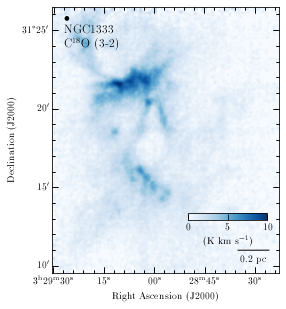

In [22]:
text_color = 'black'

hdu = fits.open(file_list_TdV[1])[0]
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='Blues').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, vmin=0.0, vmax=10, cmap=cmap, origin='lower')

plot_setup_ngc1333_wcsaxes(ax, hdu, label_col=text_color, telescope='JCMT')

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'(K km s$^{-1}$)', orientation='horizontal')
cbar.set_ticks([0, 5, 10])

fig.text(xpos_lab1, ypos_lab1, 'NGC1333', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
fig.text(xpos_lab2, ypos_lab2, r'C$^{18}$O (3-2)', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
plt.tight_layout()
fig.savefig('figs/NGC1333_C18O_TdV.pdf', dpi=200, bbox_inches='tight')

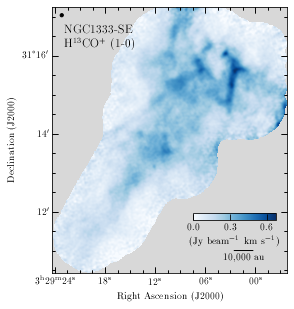

In [23]:
text_color = 'black'

hdu = fits.open(file_list_TdV[2])[0]
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='Blues').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, vmin=0.0, cmap=cmap, origin='lower')

plot_setup_ngc1333_wcsaxes(ax, hdu, label_col=text_color, telescope='NOEMA')

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'(Jy beam$^{-1}$ km s$^{-1}$)', orientation='horizontal')
cbar.set_ticks([0, 0.3, 0.6])

fig.text(xpos_lab1, ypos_lab1, 'NGC1333-SE', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
fig.text(xpos_lab2, ypos_lab2, r'H$^{13}$CO$^+$ (1-0)', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
plt.tight_layout()
fig.savefig('figs/NGC1333_H13COp_TdV.pdf', dpi=200, bbox_inches='tight')

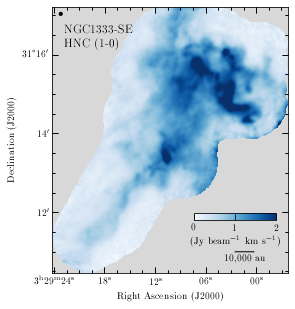

In [24]:
text_color = 'black'

hdu = fits.open(file_list_TdV[3])[0]
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='Blues').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, vmin=0, vmax=2, cmap=cmap, origin='lower')

plot_setup_ngc1333_wcsaxes(ax, hdu, label_col=text_color, telescope='NOEMA')

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'(Jy beam$^{-1}$ km s$^{-1}$)', orientation='horizontal')
# cbar.set_ticks([0, 0.1, 0.2, 0.3])

fig.text(xpos_lab1, ypos_lab1, 'NGC1333-SE', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
fig.text(xpos_lab2, ypos_lab2, r'HNC (1-0)', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
plt.tight_layout()
fig.savefig('figs/NGC1333_HNC_TdV.pdf', dpi=200, bbox_inches='tight')

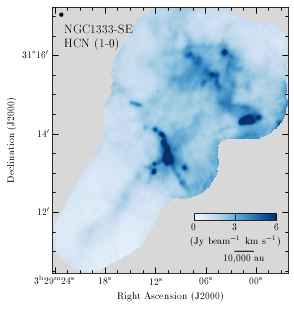

In [25]:
text_color = 'black'

hdu = fits.open(file_list_TdV[4])[0]
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='Blues').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, vmin=0, vmax=6.0, cmap=cmap, origin='lower')

plot_setup_ngc1333_wcsaxes(ax, hdu, label_col=text_color, telescope='NOEMA')

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'(Jy beam$^{-1}$ km s$^{-1}$)', orientation='horizontal')
cbar.set_ticks([0, 3, 6])

fig.text(xpos_lab1, ypos_lab1, 'NGC1333-SE', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
fig.text(xpos_lab2, ypos_lab2, r'HCN (1-0)', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
plt.tight_layout()
fig.savefig('figs/NGC1333_HCN_TdV.pdf', dpi=200, bbox_inches='tight')

### Velocity Channel Analysis (VCA)
Now we calculate the VCA for the different lines.

In [26]:
from turbustat.statistics import VCA

In [27]:
cube_13co = fits.open('data/NGC1333_13CO_1-0.fits')[0]
cube_c18o = fits.open('data/ngc1333_c18o_3-2.fits')[0]
cube_h13cop = fits.open('data/NGC1333_H13COp_L17-merged_fix_pad.fits')[0]
cube_hnc = fits.open('data/NGC1333_HNC_L23-merged_fix_pad.fits')[0]
# cube_hcn = fits.open('data/NGC1333_HCN_L21-merged_fix_pad.fits')[0]

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                   0.08310
Date:                Fri, 02 Sep 2022   Prob (F-statistic):              0.774
Time:                        12:47:48   Log-Likelihood:                -111.58
No. Observations:                 131   AIC:                             227.2
Df Residuals:                     129   BIC:                             232.9
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.7438      0.159     61.373      0.0

/Users/jpineda/opt/anaconda3/envs/py3/lib/python3.9/site-packages/turbustat/statistics/elliptical_powerlaw.py:249: RuntimeWarning: divide by zero encountered in log10
  np.log10(x**2 * term1 + x * y * term2 + y**2 * term3)


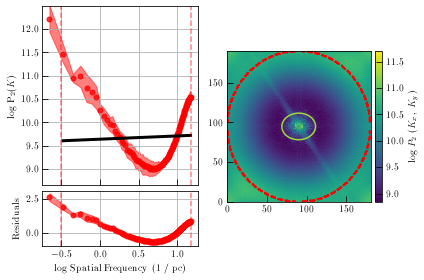

In [28]:
vca_13co = VCA(cube_13co, distance=distance)
vca_13co.run(verbose=True, xunit=u.pc**-1, beam_correct=True)

/Users/jpineda/opt/anaconda3/envs/py3/lib/python3.9/site-packages/turbustat/statistics/base_pspec2.py:442: UserWarning: The elliptical parameter is close to 1. The field may be isotropic and the fit is not converging to 1. Consider fitting with `fix_ellip_params=True`, which forces the ellipticity to 1.
  warnings.warn("The elliptical parameter is close to 1. The field "
/Users/jpineda/opt/anaconda3/envs/py3/lib/python3.9/site-packages/turbustat/statistics/elliptical_powerlaw.py:249: RuntimeWarning: divide by zero encountered in log10
  np.log10(x**2 * term1 + x * y * term2 + y**2 * term3)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.529
Model:                            OLS   Adj. R-squared:                  0.527
Method:                 Least Squares   F-statistic:                     93.05
Date:                Fri, 02 Sep 2022   Prob (F-statistic):           1.38e-18
Time:                        12:47:54   Log-Likelihood:                -528.43
No. Observations:                 222   AIC:                             1061.
Df Residuals:                     220   BIC:                             1068.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.9672      0.552     34.345      0.0

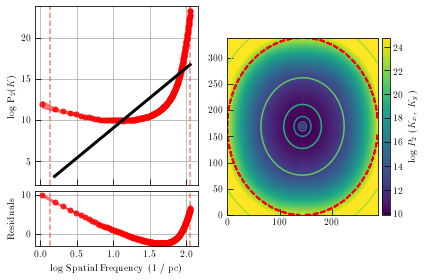

In [29]:
vca_c18o = VCA(cube_c18o, distance=distance)
vca_c18o.run(verbose=True, xunit=u.pc**-1, beam_correct=True)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.552
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                     143.5
Date:                Fri, 02 Sep 2022   Prob (F-statistic):           9.27e-28
Time:                        12:48:04   Log-Likelihood:                -1051.3
No. Observations:                 337   AIC:                             2107.
Df Residuals:                     335   BIC:                             2114.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.3156      0.931     29.341      0.0

/Users/jpineda/opt/anaconda3/envs/py3/lib/python3.9/site-packages/turbustat/statistics/elliptical_powerlaw.py:249: RuntimeWarning: divide by zero encountered in log10
  np.log10(x**2 * term1 + x * y * term2 + y**2 * term3)


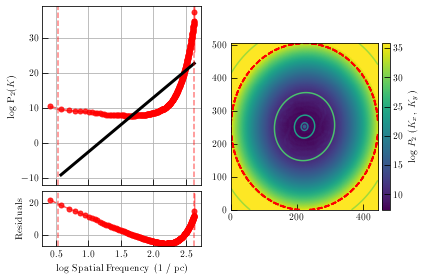

In [30]:
vca_h13cop = VCA(cube_h13cop, distance=distance)
vca_h13cop.run(verbose=True, xunit=u.pc**-1, beam_correct=True)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.531
Model:                            OLS   Adj. R-squared:                  0.530
Method:                 Least Squares   F-statistic:                     135.7
Date:                Fri, 02 Sep 2022   Prob (F-statistic):           1.10e-26
Time:                        12:48:13   Log-Likelihood:                -1110.8
No. Observations:                 349   AIC:                             2226.
Df Residuals:                     347   BIC:                             2233.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         28.2901      0.975     29.015      0.0

/Users/jpineda/opt/anaconda3/envs/py3/lib/python3.9/site-packages/turbustat/statistics/elliptical_powerlaw.py:249: RuntimeWarning: divide by zero encountered in log10
  np.log10(x**2 * term1 + x * y * term2 + y**2 * term3)


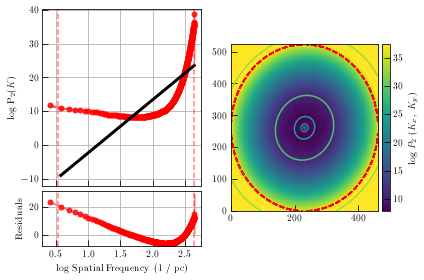

In [31]:
vca_hnc = VCA(cube_hnc, distance=distance)
vca_hnc.run(verbose=True, xunit=u.pc**-1, beam_correct=True)

### Velocity Power Spectrum
Now we calculate the power spectrum for the different lines, already padded to the mean velocity.

In [32]:
from turbustat.statistics import PowerSpectrum

In [33]:
vc_13co = fits.open('data/NGC1333_13CO_1-0-Mom1.fits')[0]
vc_c18o = fits.open('data/NGC1333_SE_C18O-Mom1_QA_pad.fits')[0]
vc_h13cop = fits.open('data/NGC1333_H13COp_L17-Mom1_QA_pad.fits')[0]
vc_hnc = fits.open('data/NGC1333_HNC_L23-Mom1_QA_pad.fits')[0]
# vc_hcn = fits.open('data/NGC1333_HCN_L21-Mom1_QA_pad.fits')[0]

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     1.698
Date:                Fri, 02 Sep 2022   Prob (F-statistic):              0.195
Time:                        12:48:15   Log-Likelihood:                -129.81
No. Observations:                 131   AIC:                             263.6
Df Residuals:                     129   BIC:                             269.4
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.9830      0.170     29.354      0.0

/Users/jpineda/opt/anaconda3/envs/py3/lib/python3.9/site-packages/turbustat/statistics/elliptical_powerlaw.py:249: RuntimeWarning: divide by zero encountered in log10
  np.log10(x**2 * term1 + x * y * term2 + y**2 * term3)


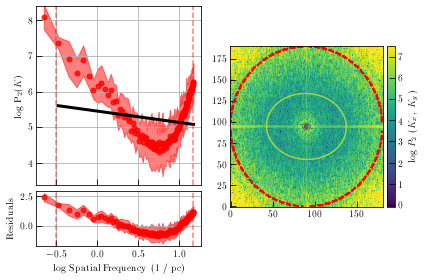

In [34]:
pspec_13co_vc = PowerSpectrum(vc_13co, distance=distance)
pspec_13co_vc.run(verbose=True, xunit=u.pc**-1, beam_correct=True) #high_cut=1/(50*u.arcsec))

/Users/jpineda/opt/anaconda3/envs/py3/lib/python3.9/site-packages/turbustat/statistics/base_pspec2.py:442: UserWarning: The elliptical parameter is close to 1. The field may be isotropic and the fit is not converging to 1. Consider fitting with `fix_ellip_params=True`, which forces the ellipticity to 1.
  warnings.warn("The elliptical parameter is close to 1. The field "
/Users/jpineda/opt/anaconda3/envs/py3/lib/python3.9/site-packages/turbustat/statistics/elliptical_powerlaw.py:249: RuntimeWarning: divide by zero encountered in log10
  np.log10(x**2 * term1 + x * y * term2 + y**2 * term3)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.523
Model:                            OLS   Adj. R-squared:                  0.521
Method:                 Least Squares   F-statistic:                     84.47
Date:                Fri, 02 Sep 2022   Prob (F-statistic):           3.03e-17
Time:                        12:48:19   Log-Likelihood:                -557.65
No. Observations:                 222   AIC:                             1119.
Df Residuals:                     220   BIC:                             1126.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.9370      0.636     23.470      0.0

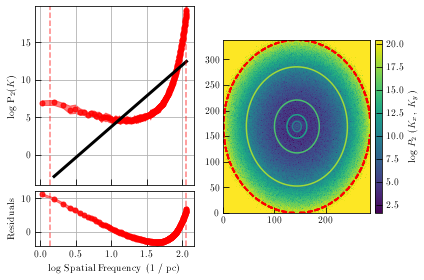

In [35]:
pspec_c18o_vc = PowerSpectrum(vc_c18o, distance=distance)
pspec_c18o_vc.run(verbose=True, xunit=u.pc**-1, beam_correct=True)#, high_cut=1/(16*u.arcsec))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.532
Model:                            OLS   Adj. R-squared:                  0.530
Method:                 Least Squares   F-statistic:                     130.3
Date:                Fri, 02 Sep 2022   Prob (F-statistic):           1.02e-25
Time:                        12:48:25   Log-Likelihood:                -1041.5
No. Observations:                 337   AIC:                             2087.
Df Residuals:                     335   BIC:                             2095.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.0972      0.910     25.379      0.0

/Users/jpineda/opt/anaconda3/envs/py3/lib/python3.9/site-packages/turbustat/statistics/elliptical_powerlaw.py:249: RuntimeWarning: divide by zero encountered in log10
  np.log10(x**2 * term1 + x * y * term2 + y**2 * term3)


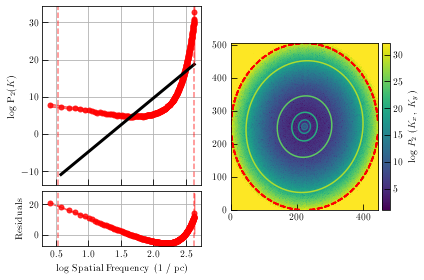

In [36]:
pspec_h13cop_vc = PowerSpectrum(vc_h13cop, distance=distance)
pspec_h13cop_vc.run(verbose=True, xunit=u.pc**-1, beam_correct=True)#, high_cut=1/(5*u.arcsec))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.517
Method:                 Least Squares   F-statistic:                     129.3
Date:                Fri, 02 Sep 2022   Prob (F-statistic):           1.12e-25
Time:                        12:48:30   Log-Likelihood:                -1099.7
No. Observations:                 349   AIC:                             2203.
Df Residuals:                     347   BIC:                             2211.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.7001      0.946     25.058      0.0

/Users/jpineda/opt/anaconda3/envs/py3/lib/python3.9/site-packages/turbustat/statistics/elliptical_powerlaw.py:249: RuntimeWarning: divide by zero encountered in log10
  np.log10(x**2 * term1 + x * y * term2 + y**2 * term3)


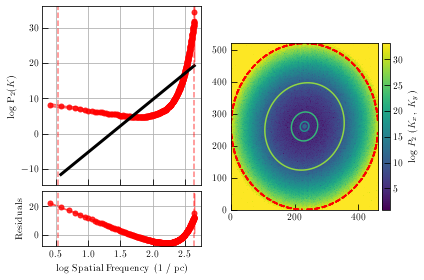

In [37]:
pspec_hnc_vc = PowerSpectrum(vc_hnc, distance=distance)
pspec_hnc_vc.run(verbose=True, xunit=u.pc**-1, beam_correct=True)#, high_cut=1/(5*u.arcsec))

In [38]:
# pspec_hcn_vc = PowerSpectrum(vc_hcn, distance=distance)
# pspec_hcn_vc.run(verbose=True, xunit=u.pc**-1, beam_correct=True)#, high_cut=1/(5*u.arcsec))

### Power Spectrum of Intensity

In [41]:
TdV_13co = fits.open('data/NGC1333_13CO_1-0-TdV.fits')[0]
TdV_c18o = fits.open('data/NGC1333_SE_C18O-TdV.fits')[0]
TdV_h13cop = fits.open('data/NGC1333_H13COp_L17-TdV_pad.fits')[0]
TdV_hnc = fits.open('data/NGC1333_HNC_L23-TdV_pad.fits')[0]
# TdV_hcn = fits.open('data/NGC1333_HCN_L21-TdV_pad.fits')[0]

# TdV_hnc_nopad = fits.open('data/NGC1333_HNC_L23-TdV.fits')[0]
# TdV_hcn_nopad = fits.open('data/NGC1333_HCN_L21-TdV.fits')[0]

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     4862.
Date:                Mon, 05 Sep 2022   Prob (F-statistic):          2.83e-104
Time:                        15:50:48   Log-Likelihood:                 86.069
No. Observations:                 131   AIC:                            -168.1
Df Residuals:                     129   BIC:                            -162.4
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8136      0.030     61.469      0.0

/Users/jpineda/opt/anaconda3/envs/py3/lib/python3.9/site-packages/turbustat/statistics/elliptical_powerlaw.py:249: RuntimeWarning: divide by zero encountered in log10
  np.log10(x**2 * term1 + x * y * term2 + y**2 * term3)


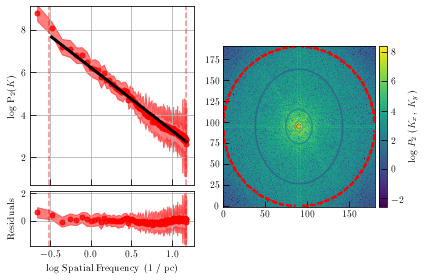

In [95]:
pspec_13co_TdV = PowerSpectrum(TdV_13co, distance=distance)
pspec_13co_TdV.run(verbose=True, xunit=u.pc**-1, beam_correct=False)#, high_cut=1/(50*u.arcsec))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     2006.
Date:                Mon, 05 Sep 2022   Prob (F-statistic):          1.52e-112
Time:                        15:50:57   Log-Likelihood:                -72.516
No. Observations:                 222   AIC:                             149.0
Df Residuals:                     220   BIC:                             155.8
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8528      0.059     14.509      0.0

/Users/jpineda/opt/anaconda3/envs/py3/lib/python3.9/site-packages/turbustat/statistics/elliptical_powerlaw.py:249: RuntimeWarning: divide by zero encountered in log10
  np.log10(x**2 * term1 + x * y * term2 + y**2 * term3)


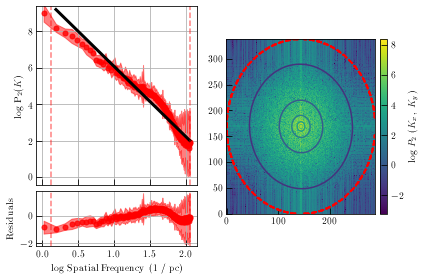

In [96]:
pspec_c18o_TdV = PowerSpectrum(TdV_c18o, distance=distance)
pspec_c18o_TdV.run(verbose=True, xunit=u.pc**-1, beam_correct=False)#, high_cut=1/(16*u.arcsec))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     5186.
Date:                Mon, 05 Sep 2022   Prob (F-statistic):          6.40e-206
Time:                        15:50:11   Log-Likelihood:                 92.098
No. Observations:                 337   AIC:                            -180.2
Df Residuals:                     335   BIC:                            -172.6
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6010      0.026     23.054      0.0

/Users/jpineda/opt/anaconda3/envs/py3/lib/python3.9/site-packages/turbustat/statistics/elliptical_powerlaw.py:249: RuntimeWarning: divide by zero encountered in log10
  np.log10(x**2 * term1 + x * y * term2 + y**2 * term3)


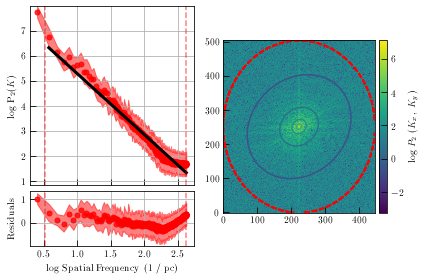

In [92]:
pspec_h13cop_TdV = PowerSpectrum(TdV_h13cop, distance=distance)
pspec_h13cop_TdV.run(verbose=True, xunit=u.pc**-1, beam_correct=False)#, high_cut=1/(16*u.arcsec))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     9904.
Date:                Mon, 05 Sep 2022   Prob (F-statistic):          3.29e-257
Time:                        15:50:45   Log-Likelihood:                 129.71
No. Observations:                 349   AIC:                            -255.4
Df Residuals:                     347   BIC:                            -247.7
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1399      0.022     52.210      0.0

/Users/jpineda/opt/anaconda3/envs/py3/lib/python3.9/site-packages/turbustat/statistics/elliptical_powerlaw.py:249: RuntimeWarning: divide by zero encountered in log10
  np.log10(x**2 * term1 + x * y * term2 + y**2 * term3)


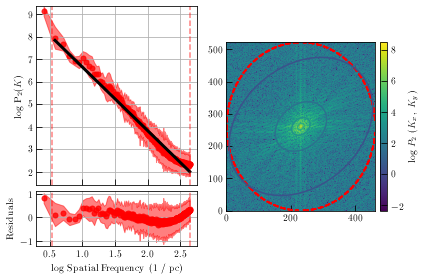

In [94]:
pspec_hnc_TdV = PowerSpectrum(TdV_hnc, distance=distance)
pspec_hnc_TdV.run(verbose=True, xunit=u.pc**-1, beam_correct=False)#, high_cut=1/(16*u.arcsec))

In [46]:
# pspec_hcn_TdV = PowerSpectrum(TdV_hcn, distance=distance)
# pspec_hcn_TdV.run(verbose=True, xunit=u.pc**-1, beam_correct=True)# , high_cut=1/(6*u.arcsec))

### Conversion of pixel units to pc

In [47]:
conv_13co = np.abs((pspec_13co_TdV.header['CDELT1'] * u.deg.to('', equivalencies=u.dimensionless_angles()))*distance).to(u.pc)
conv_c18o = np.abs((pspec_c18o_TdV.header['CDELT1'] * u.deg.to('', equivalencies=u.dimensionless_angles()))*distance).to(u.pc)
conv_h13cop = np.abs((pspec_h13cop_TdV.header['CDELT1'] * u.deg.to('', equivalencies=u.dimensionless_angles()))*distance).to(u.pc)
conv_hnc = np.abs((pspec_hnc_TdV.header['CDELT1'] * u.deg.to('', equivalencies=u.dimensionless_angles()))*distance).to(u.pc)
# conv_hcn = np.abs((pspec_hcn_TdV.header['CDELT1'] * u.deg.to('', equivalencies=u.dimensionless_angles()))*distance).to(u.pc)

In [48]:
beam_multiple = 3.0 
gd_13co_vc = (pspec_13co_vc.freqs.value < np.abs(pspec_13co_vc.header['CDELT1']) / pspec_13co_vc.header['BMAJ'] / beam_multiple)
gd_c18o_vc = (pspec_c18o_vc.freqs.value < np.abs(pspec_c18o_vc.header['CDELT1']) / pspec_c18o_vc.header['BMAJ'] / beam_multiple)

gd_h13cop_vc = (pspec_h13cop_vc.freqs.value < np.abs(pspec_h13cop_vc.header['CDELT1']) / pspec_h13cop_vc.header['BMAJ'] / beam_multiple)
# gd_hcn_vc = (pspec_hcn_vc.freqs.value < np.abs(pspec_hcn_vc.header['CDELT1']) / pspec_hcn_vc.header['BMAJ'] / beam_multiple)
gd_hnc_vc = (pspec_hnc_vc.freqs.value < np.abs(pspec_hnc_vc.header['CDELT1']) / pspec_hnc_vc.header['BMAJ'] / beam_multiple)

In [49]:
# beam_multiple = 3.0 
gd_13co_TdV = (pspec_13co_TdV.freqs.value < np.abs(pspec_13co_TdV.header['CDELT1']) / pspec_13co_TdV.header['BMAJ'] / beam_multiple)
gd_c18o_TdV = (pspec_c18o_TdV.freqs.value < np.abs(pspec_c18o_TdV.header['CDELT1']) / pspec_c18o_TdV.header['BMAJ'] / beam_multiple)

gd_h13cop_TdV = (pspec_h13cop_TdV.freqs.value < np.abs(pspec_h13cop_TdV.header['CDELT1']) / pspec_h13cop_TdV.header['BMAJ'] / beam_multiple)
# gd_hcn_TdV = (pspec_hcn_TdV.freqs.value < np.abs(pspec_hcn_TdV.header['CDELT1']) / pspec_hcn_TdV.header['BMAJ'] / beam_multiple)
gd_hnc_TdV = (pspec_hnc_TdV.freqs.value < np.abs(pspec_hnc_TdV.header['CDELT1']) / pspec_hnc_TdV.header['BMAJ'] / beam_multiple)


In [50]:
# beam_multiple = 3.0 
gd_13co_VCA = (vca_13co.freqs.value < np.abs(vca_13co.header['CDELT1']) / pspec_13co_TdV.header['BMAJ'] / beam_multiple)
gd_c18o_VCA = (vca_c18o.freqs.value < np.abs(vca_c18o.header['CDELT1']) / pspec_c18o_TdV.header['BMAJ'] / beam_multiple)

gd_h13cop_VCA = (vca_h13cop.freqs.value < np.abs(vca_h13cop.header['CDELT1']) / vca_h13cop.header['BMAJ'] / beam_multiple)
# gd_hcn_VCA = (vca_hcn.freqs.value < np.abs(vca_hcn.header['CDELT1']) / vca_hcn.header['BMAJ'] / beam_multiple)
gd_hnc_VCA = (vca_hnc.freqs.value < np.abs(vca_hnc.header['CDELT1']) / vca_hnc.header['BMAJ'] / beam_multiple)


The goal is to combine the power-spectrum from the different tracers using scaling parameters for $^{13}$CO and  C$^{18}$O, $f_{13}$ and $f_{18}$. The model can be written as:
\begin{equation}
P(k) = A k^{\beta}~,
\end{equation}
where the data for C$^{18}$O is used as anchor.

In [51]:
ln_log = np.log10(np.exp(1))

k_mhd_wave = (1. / 37e-3)
log_k_mhd_wave = np.log10(k_mhd_wave)

# 13CO 1-0
# linear and log quantities
#
freq_13co_TdV = (pspec_13co_TdV.freqs[gd_13co_TdV] / conv_13co).value
log_freq_13co_TdV = np.log10(freq_13co_TdV)
P_TdV_13co = pspec_13co_TdV.ps1D[gd_13co_TdV] * 1e-7
log_P_TdV_13co = np.log10(P_TdV_13co)
eP_TdV_13co = pspec_13co_TdV.ps1D_stddev[gd_13co_TdV] * 1e-7
elogP_TdV_13co = ln_log * eP_TdV_13co / P_TdV_13co

# C18O 3-2
# linear and log quantities
#
freq_c18o_TdV = (pspec_c18o_TdV.freqs[gd_c18o_TdV] / conv_c18o).value
log_freq_c18o_TdV = np.log10(freq_c18o_TdV)
P_TdV_c18o = pspec_c18o_TdV.ps1D[gd_c18o_TdV] * 1e-7
log_P_TdV_c18o = np.log10(P_TdV_c18o)
eP_TdV_c18o = pspec_c18o_TdV.ps1D_stddev[gd_c18o_TdV] * 1e-7
elogP_TdV_c18o = ln_log * eP_TdV_c18o / P_TdV_c18o

# H13CO+ 1-0
# linear and log quantities
#
freq_h13cop_TdV = (pspec_h13cop_TdV.freqs[gd_h13cop_TdV] / conv_h13cop).value
log_freq_h13cop_TdV = np.log10(freq_h13cop_TdV)
P_TdV_h13cop = pspec_h13cop_TdV.ps1D[gd_h13cop_TdV] * 1e-7
log_P_TdV_h13cop = np.log10(P_TdV_h13cop)
eP_TdV_h13cop = pspec_h13cop_TdV.ps1D_stddev[gd_h13cop_TdV] * 1e-7
elogP_TdV_h13cop = ln_log * eP_TdV_h13cop / P_TdV_h13cop

# HNC 1-0
# linear and log quantities
#
freq_hnc_TdV = (pspec_hnc_TdV.freqs[gd_hnc_TdV] / conv_hnc).value
log_freq_hnc_TdV = np.log10(freq_hnc_TdV)
P_TdV_hnc = pspec_hnc_TdV.ps1D[gd_hnc_TdV] * 1e-7
log_P_TdV_hnc = np.log10(P_TdV_hnc)
eP_TdV_hnc = pspec_hnc_TdV.ps1D_stddev[gd_hnc_TdV] * 1e-7
elogP_TdV_hnc = ln_log * eP_TdV_hnc / P_TdV_hnc

freq_all_hnc_TdV = np.append(freq_13co_TdV, np.append(freq_c18o_TdV, freq_hnc_TdV))
freq_all_h13cop_TdV = np.append(freq_13co_TdV, np.append(freq_c18o_TdV, freq_h13cop_TdV))

log_freq_all_hnc_TdV = np.append(log_freq_13co_TdV, 
                                 np.append(log_freq_c18o_TdV, log_freq_hnc_TdV))
log_freq_all_h13cop_TdV = np.append(log_freq_13co_TdV, 
                                    np.append(log_freq_c18o_TdV, log_freq_h13cop_TdV))

log_freq_all_hnc_TdV_f = np.append(log_freq_13co_TdV[1:], 
                                 np.append(log_freq_c18o_TdV[1:], log_freq_hnc_TdV[1:]))
log_freq_all_h13cop_TdV_f = np.append(log_freq_13co_TdV[1:], 
                                    np.append(log_freq_c18o_TdV[1:], log_freq_h13cop_TdV[1:]))

#
# Define functions for fitting. 
#
def log_prior_TdV_HNC(theta):
    A, beta, f_13, f_hnc = theta
    if 1.0 < A < 2.5 and -3.4 < beta < -2.0 and 1e2 < f_13 < 1e3 and 0.02 < f_hnc < 1.0:
        return 0.0
    return -np.inf

def log_likelihood_log_TdV_HNC(theta):
    """ Likelihood function for working on log-log"""
    A, beta, f_13, f_hnc = theta
    model_all_hnc = A + log_freq_all_hnc_TdV_f * beta
    log_P_TdV_all_hnc = np.append(np.log10(f_13) + log_P_TdV_13co[1:], 
                                  np.append(log_P_TdV_c18o[1:], 
                                            np.log10(f_hnc) + log_P_TdV_hnc[1:])
                                 )
    sigma_all_hnc = np.append(elogP_TdV_13co[1:], 
                              np.append(elogP_TdV_c18o[1:], elogP_TdV_hnc[1:])
                             )
    return -0.5 * np.sum((log_P_TdV_all_hnc - model_all_hnc)**2 / sigma_all_hnc**2)


def log_probability_log_TdV_HNC(theta):
    lp = log_prior_TdV_HNC(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_log_TdV_HNC(theta)

#
# 
#
def log_prior_TdV_H13COp(theta):
    A, beta, f_13, f_h13cop = theta
    if 1.0 < A < 2.5 and -3.4 < beta < -2.0 and 1e2 < f_13 < 1e3 and 0.4 < f_h13cop < 15.0:
        return 0.0
    return -np.inf

def log_likelihood_log_TdV_H13COp(theta):
    A, beta, f_13, f_h13cop = theta
    model_all_h13cop = A + log_freq_all_h13cop_TdV_f * beta
    log_P_TdV_all_h13cop = np.append(np.log10(f_13) + log_P_TdV_13co[1:],
                                     np.append(log_P_TdV_c18o[1:], 
                                               np.log10(f_h13cop) + log_P_TdV_h13cop[1:])
                                    )
    sigma_all_h13cop = np.append(elogP_TdV_13co[1:], 
                                 np.append(elogP_TdV_c18o[1:], elogP_TdV_h13cop[1:])
                                )
    return -0.5 * np.sum((log_P_TdV_all_h13cop - model_all_h13cop)**2 / sigma_all_h13cop**2)

def log_probability_log_TdV_H13COp(theta):
    lp = log_prior_TdV_H13COp(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_log_TdV_H13COp(theta)

In [97]:
from scipy.optimize import minimize

nll = lambda *args: -log_likelihood_log_TdV_HNC(*args)
initial = np.array([1.8, -2.7, 300., 0.15])
soln_log_hnc = minimize(nll, initial)
print(soln_log_hnc.x)

[ 1.76659955e+00 -2.73439249e+00  2.99473996e+02  1.43330943e-01]


In [98]:
nll = lambda *args: -log_likelihood_log_TdV_H13COp(*args)
initial = np.array([1.8, -2.7, 290., 2.5])
soln_log_h13cop = minimize(nll, initial)
print(soln_log_h13cop.x)

[  1.74412058  -2.70557536 289.83747224   2.54949513]


## Power Spectrum of Velocity

In [54]:
ln_log = np.log10(np.exp(1))

# 13CO 1-0
# linear and log quantities
#
freq_13co_vc = (pspec_13co_vc.freqs[gd_13co_vc] / conv_13co).value
log_freq_13co_vc = np.log10(freq_13co_vc)
P_vc_13co = pspec_13co_vc.ps1D[gd_13co_vc] * 1e-6
log_P_vc_13co = np.log10(P_vc_13co)
eP_vc_13co = pspec_13co_vc.ps1D_stddev[gd_13co_vc] * 1e-6
elogP_vc_13co = ln_log * eP_vc_13co / P_vc_13co

# C18O 3-2
# linear and log quantities
#
freq_c18o_vc = (pspec_c18o_vc.freqs[gd_c18o_vc] / conv_c18o).value
log_freq_c18o_vc = np.log10(freq_c18o_vc)
P_vc_c18o = pspec_c18o_vc.ps1D[gd_c18o_vc] * 1e-6
log_P_vc_c18o = np.log10(P_vc_c18o)
eP_vc_c18o = pspec_c18o_vc.ps1D_stddev[gd_c18o_vc] * 1e-6
elogP_vc_c18o = ln_log * eP_vc_c18o / P_vc_c18o

# H13CO+ 1-0
# linear and log quantities
#
freq_h13cop_vc = (pspec_h13cop_vc.freqs[gd_h13cop_vc] / conv_h13cop).value
log_freq_h13cop_vc = np.log10(freq_h13cop_vc)
P_vc_h13cop = pspec_h13cop_vc.ps1D[gd_h13cop_vc] * 1e-6
log_P_vc_h13cop = np.log10(P_vc_h13cop)
eP_vc_h13cop = pspec_h13cop_vc.ps1D_stddev[gd_h13cop_vc] * 1e-6
elogP_vc_h13cop = ln_log * eP_vc_h13cop / P_vc_h13cop

# HNC 1-0
# linear and log quantities
#
freq_hnc_vc = (pspec_hnc_vc.freqs[gd_hnc_vc] / conv_hnc).value
log_freq_hnc_vc = np.log10(freq_hnc_vc)
P_vc_hnc = pspec_hnc_vc.ps1D[gd_hnc_vc] * 1e-6
log_P_vc_hnc = np.log10(P_vc_hnc)
eP_vc_hnc = pspec_hnc_vc.ps1D_stddev[gd_hnc_vc] * 1e-6
elogP_vc_hnc = ln_log * eP_vc_hnc / P_vc_hnc

freq_all_hnc_vc = np.append(freq_13co_vc, np.append(freq_c18o_vc, freq_hnc_vc))
freq_all_h13cop_vc = np.append(freq_13co_vc, np.append(freq_c18o_vc, freq_h13cop_vc))

log_freq_all_hnc_vc = np.append(log_freq_13co_vc,
                                 np.append(log_freq_c18o_vc, log_freq_hnc_vc))
log_freq_all_h13cop_vc = np.append(log_freq_13co_vc, 
                                    np.append(log_freq_c18o_vc, log_freq_h13cop_vc))

log_freq_all_hnc_vc_f = np.append(log_freq_13co_vc[1:],
                                 np.append(log_freq_c18o_vc[1:], log_freq_hnc_vc[1:]))
log_freq_all_h13cop_vc_f = np.append(log_freq_13co_vc[1:], 
                                    np.append(log_freq_c18o_vc[1:], log_freq_h13cop_vc[1:]))

#
# Define functions for fitting. 
#
def log_prior_vc_HNC(theta):
    A, beta, f_13, f_hnc = theta
    if 0.7 < A < 2.3 and -3.2 < beta < -2.0 and 6.0 < f_13 < 6e1 and 7e-3 < f_hnc < 7e-2:
        return 0.0
    return -np.inf

def log_likelihood_log_vc_HNC(theta):
    """ Likelihood function for working on log-log"""
    A, beta, f_13, f_hnc = theta
    model = A + log_freq_all_hnc_vc_f * beta
    data = np.append(np.log10(f_13) + log_P_vc_13co[1:], 
                     np.append(log_P_vc_c18o[1:], 
                               np.log10(f_hnc) + log_P_vc_hnc[1:])
                    )
    sigma_all = np.append(elogP_vc_13co[1:], 
                          np.append(elogP_vc_c18o[1:], elogP_vc_hnc[1:])
                         )
    return -0.5 * np.sum((data - model)**2 / sigma_all**2)

def log_probability_log_vc_HNC(theta):
    lp = log_prior_vc_HNC(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_log_vc_HNC(theta)

# array([ 1.37398059, -2.50671892, 17.35404341,  0.0387673 ])

def log_prior_vc_H13COp(theta):
    A, beta, f_13, f_h13cop = theta
    if 0.7 < A < 2.3 and -3.2 < beta < -2.0 and 6.0 < f_13 < 6e1 and 1e-2 < f_h13cop < 0.1:
        return 0.0
    return -np.inf

def log_likelihood_log_vc_H13COp(theta):
    """ Likelihood function for working on log-log"""
    A, beta, f_13, f_h13cop = theta
    model = A + log_freq_all_h13cop_vc_f * beta
    data = np.append(np.log10(f_13) + log_P_vc_13co[1:], 
                     np.append(log_P_vc_c18o[1:], 
                               np.log10(f_h13cop) + log_P_vc_h13cop[1:])
                               )
    sigma_all = np.append(elogP_vc_13co[1:], 
                          np.append(elogP_vc_c18o[1:], elogP_vc_h13cop[1:])
                         )
    return -0.5 * np.sum((data - model)**2 / sigma_all**2)

def log_probability_log_vc_H13COp(theta):
    lp = log_prior_vc_H13COp(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_log_vc_H13COp(theta)

In [55]:
from scipy.optimize import minimize

nll = lambda *args: -log_likelihood_log_vc_HNC(*args)
initial = np.array([1.3, -2.4, 13., 0.01])
soln_log_hnc_vc = minimize(nll, initial)
print(soln_log_hnc_vc.x)


[ 1.4255659  -2.56656827 19.12442323  0.02151242]


In [56]:
nll = lambda *args: -log_likelihood_log_vc_H13COp(*args)
initial = np.array([np.log10(16.), -2.4, 13.5, 0.03])
soln_log_h13cop_vc = minimize(nll, initial)
print(soln_log_h13cop_vc.x)

[ 1.37398059 -2.50671892 17.35404341  0.0387673 ]


## Velocity Channel Analysis (VCA)

In [106]:
ln_log = np.log10(np.exp(1))

# 13CO 1-0
# linear and log quantities
#
freq_vca_13co = (vca_13co.freqs[gd_13co_VCA] / conv_13co).value
log_freq_vca_13co = np.log10(freq_vca_13co)
P_vca_13co = vca_13co.ps1D[gd_13co_VCA] * 1e-6
log_P_vca_13co = np.log10(P_vca_13co)
eP_vca_13co = vca_13co.ps1D_stddev[gd_13co_VCA] * 1e-6
elogP_vca_13co = ln_log * eP_vca_13co / P_vca_13co

# C18O 3-2
# linear and log quantities
#
freq_vca_c18o = (vca_c18o.freqs[gd_c18o_VCA] / conv_c18o).value
log_freq_vca_c18o = np.log10(freq_vca_c18o)
P_vca_c18o = vca_c18o.ps1D[gd_c18o_VCA] * 1e-6
log_P_vca_c18o = np.log10(P_vca_c18o)
eP_vca_c18o = vca_c18o.ps1D_stddev[gd_c18o_VCA] * 1e-6
elogP_vca_c18o = ln_log * eP_vca_c18o / P_vca_c18o

# H13CO+ 1-0
# linear and log quantities
#
freq_vca_h13cop = (vca_h13cop.freqs[gd_h13cop_VCA] / conv_h13cop).value
log_freq_vca_h13cop = np.log10(freq_vca_h13cop)
P_vca_h13cop = vca_h13cop.ps1D[gd_h13cop_VCA] * 1e-6
log_P_vca_h13cop = np.log10(P_vca_h13cop)
eP_vca_h13cop = vca_h13cop.ps1D_stddev[gd_h13cop_VCA] * 1e-6
elogP_vca_h13cop = ln_log * eP_vca_h13cop / P_vca_h13cop

# HNC 1-0
# linear and log quantities
#
freq_vca_hnc = (vca_hnc.freqs[gd_hnc_VCA] / conv_hnc).value
log_freq_vca_hnc = np.log10(freq_vca_hnc)
P_vca_hnc = vca_hnc.ps1D[gd_hnc_VCA] * 1e-6
log_P_vca_hnc = np.log10(P_vca_hnc)
eP_vca_hnc = vca_hnc.ps1D_stddev[gd_hnc_VCA] * 1e-6
elogP_vca_hnc = ln_log * eP_vca_hnc / P_vca_hnc

freq_all_vca_hnc = np.append(freq_vca_13co, np.append(freq_vca_c18o, freq_vca_hnc))
freq_all_vca_h13cop = np.append(freq_vca_13co, np.append(freq_vca_c18o, freq_vca_h13cop))

log_freq_vca_all_hnc = np.append(log_freq_vca_13co,
                                 np.append(log_freq_vca_c18o, log_freq_vca_hnc))
log_freq_vca_all_h13cop = np.append(log_freq_vca_13co, 
                                    np.append(log_freq_vca_c18o, log_freq_vca_h13cop))

log_freq_vca_all_hnc_f = np.append(log_freq_vca_13co[1:],
                                 np.append(log_freq_vca_c18o[1:], log_freq_vca_hnc[1:]))
log_freq_vca_all_h13cop_f = np.append(log_freq_vca_13co[1:], 
                                    np.append(log_freq_vca_c18o[1:], log_freq_vca_h13cop[1:]))

#
# Define functions for fitting. 
#
def log_prior_vca_HNC(theta):
    A, beta, f_13, f_hnc = theta
    if 0.7 < A < 2.3 and -3.2 < beta < -2.0 and 6.0 < f_13 < 6e2 and 1e-3 < f_hnc < 10.0:
        return 0.0
    return -np.inf

def log_likelihood_log_vca_HNC(theta):
    """ Likelihood function for working on log-log"""
    A, beta, f_13, f_hnc = theta
    model = A + log_freq_vca_all_hnc_f * beta
    data = np.append(np.log10(f_13) + log_P_vca_13co[1:], 
                     np.append(log_P_vca_c18o[1:], 
                               np.log10(f_hnc) + log_P_vca_hnc[1:])
                    )
    sigma_all = np.append(elogP_vca_13co[1:], 
                          np.append(elogP_vca_c18o[1:], elogP_vca_hnc[1:])
                         )
    return -0.5 * np.sum((data - model)**2 / sigma_all**2)

def log_probability_log_vca_HNC(theta):
    lp = log_prior_vca_HNC(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_log_vca_HNC(theta)

# array([ 1.37398059, -2.50671892, 17.35404341,  0.0387673 ])

def log_prior_vca_H13COp(theta):
    A, beta, f_13, f_h13cop = theta
    if 0.7 < A < 2.3 and -3.2 < beta < -2.0 and 6.0 < f_13 < 6e2 and 1e-3 < f_h13cop < 10.0:
        return 0.0
    return -np.inf

def log_likelihood_log_vca_H13COp(theta):
    """ Likelihood function for working on log-log"""
    A, beta, f_13, f_h13cop = theta
    model = A + log_freq_vca_all_h13cop_f * beta
    data = np.append(np.log10(f_13) + log_P_vca_13co[1:], 
                     np.append(log_P_vca_c18o[1:], 
                               np.log10(f_h13cop) + log_P_vca_h13cop[1:])
                               )
    sigma_all = np.append(elogP_vca_13co[1:], 
                          np.append(elogP_vca_c18o[1:], elogP_vca_h13cop[1:])
                         )
    return -0.5 * np.sum((data - model)**2 / sigma_all**2)

def log_probability_log_vca_H13COp(theta):
    lp = log_prior_vca_H13COp(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_log_vca_H13COp(theta)

In [111]:
from scipy.optimize import minimize

nll = lambda *args: -log_likelihood_log_vca_HNC(*args)
initial = np.array([5.5, -1.4, 40., 0.2])
soln_log_vca_hnc = minimize(nll, initial)
print(soln_log_vca_hnc.x)


[ 5.80446733 -1.71900503 44.13868838  2.87079784]


In [112]:
nll = lambda *args: -log_likelihood_log_vca_H13COp(*args)
initial = np.array([5.5, -1.4, 40.0, 0.2])
soln_log_vca_h13cop = minimize(nll, initial)
print(soln_log_vca_h13cop.x)

[ 5.67177365 -1.58636155 35.71632545 25.24764278]


## Combine different datasets for plotting

In [86]:
def plot_powerspectrum(ax, solution, spectrum='ps_vc', ps_vc=True, do_hnc=True, label_power_fit=None):
    """
    """
#     fig, ax = plt.subplots(figsize=(5, 4))
    if (spectrum != 'ps_vc') & (spectrum != 'ps_TdV') & (spectrum != 'ps_vca'):
        print('ps_vc, ps_TdV, and ps_vca')
        return None
    A = solution[0]
    beta = solution[1]
    f_data1 = solution[2]
    f_data3 = solution[3]
    
    if label_power_fit == None:
        label_power_fit = r'$\propto k^{'
        label_power_fit = label_power_fit + '{0}'.format(np.round(beta, decimals=1)) + '}$'
    
    label_1 = r'$^{13}$CO'
    label_2 = r'C$^{18}$O'
    if spectrum == 'ps_vc':
        #
        text_pspec = 'Velocity Power Spectrum'
        log_x_data1 = log_freq_13co_vc
        log_y_data1 = np.log10(f_data1) + log_P_vc_13co
        elog_y_data1 = elogP_vc_13co
        #
        log_x_data2 = log_freq_c18o_vc
        log_y_data2 = log_P_vc_c18o
        elog_y_data2 = elogP_vc_c18o
        if do_hnc:
            log_x_data3 = log_freq_hnc_vc
            log_y_data3 = np.log10(f_data3) + log_P_vc_hnc
            elog_y_data3 = elogP_vc_hnc
            label_3 = r'HNC'
        else:
            log_x_data3 = log_freq_h13cop_vc
            log_y_data3 = np.log10(f_data3) + log_P_vc_h13cop
            elog_y_data3 = elogP_vc_h13cop
            label_3 = r'H$^{13}$CO$^+$'
    elif spectrum == 'ps_TdV':
        text_pspec = 'Intensity Power Spectrum'
        #
        log_x_data1 = log_freq_13co_TdV
        log_y_data1 = np.log10(f_data1) + log_P_TdV_13co
        elog_y_data1 = elogP_TdV_13co
        #
        log_x_data2 = log_freq_c18o_TdV
        log_y_data2 = log_P_TdV_c18o
        elog_y_data2 = elogP_TdV_c18o
        if do_hnc:
            log_x_data3 = log_freq_hnc_TdV
            log_y_data3 = np.log10(f_data3) + log_P_TdV_hnc
            elog_y_data3 = elogP_TdV_hnc
            label_3 = r'HNC'
        else:
            log_x_data3 = log_freq_h13cop_TdV
            log_y_data3 = np.log10(f_data3) + log_P_TdV_h13cop
            elog_y_data3 = elogP_TdV_h13cop
            label_3 = r'H$^{13}$CO$^+$'
    else:
        text_pspec = 'VCA'
        #
        log_x_data1 = log_freq_vca_13co
        log_y_data1 = np.log10(f_data1) + log_P_vca_13co
        elog_y_data1 = elogP_vca_13co
        #
        log_x_data2 = log_freq_vca_c18o
        log_y_data2 = log_P_vca_c18o
        elog_y_data2 = elogP_vca_c18o
        if do_hnc:
            log_x_data3 = log_freq_vca_hnc
            log_y_data3 = np.log10(f_data3) + log_P_vca_hnc
            elog_y_data3 = elogP_vca_hnc
            label_3 = r'HNC'
        else:
            log_x_data3 = log_freq_vca_h13cop
            log_y_data3 = np.log10(f_data3) + log_P_vca_h13cop
            elog_y_data3 = elogP_vca_h13cop
            label_3 = r'H$^{13}$CO$^+$'
            
    ax.errorbar(log_x_data1, log_y_data1, yerr=elog_y_data1, 
                alpha=0.5, markeredgecolor='k', label=label_1, fmt="o")
    ax.errorbar(log_x_data2, log_y_data2, yerr=elog_y_data2, 
                alpha=0.5, markeredgecolor='k', label=label_2, fmt="o")
    ax.errorbar(log_x_data3, log_y_data3, yerr=elog_y_data3, 
                alpha=0.5, markeredgecolor='k', label=label_3, fmt="o")

    x_sample = np.log10(np.array([0.3, 50]))
    ax.plot(x_sample, A + x_sample * beta, color='w', lw=3)
    ax.plot(x_sample, A + x_sample * beta, color='k', lw=2, ls=':')

    plt.legend(frameon=False)
    ax.set_xlabel(r'log (Spatial Frequency) (pc$^{-1}$)')
    ax.set_ylabel(r'log ($P_2(K)$), Arbitrary Units')
 
    ax.text(-0.1, A - 0.1 * beta + 1, label_power_fit, horizontalalignment='center')

    ax.text(0.2, 0.2, text_pspec, horizontalalignment='center', transform=ax.transAxes)
#         ax.text(-0.25, -1, text_pspec, horizontalalignment='center', transform=ax.transAxes)

    y_k_mhd = A + log_k_mhd_wave * beta
    ax.plot([log_k_mhd_wave, log_k_mhd_wave], y_k_mhd + np.array([-1, 1]), color='gray')
    ax.text(log_k_mhd_wave, y_k_mhd + 1.5, '37 mpc', horizontalalignment='center')


    ax.set_xlim(-1, 2)
    plt.tight_layout()
    return

### Velocity Power Spectrum

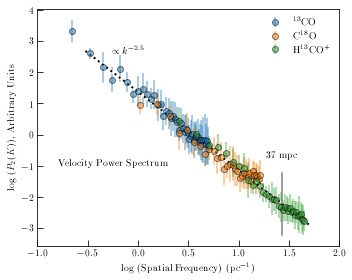

In [72]:
fig, ax = plt.subplots(figsize=(5, 4))
plot_powerspectrum(ax, soln_log_h13cop_vc.x, spectrum='ps_vc', do_hnc=False)
fig.savefig('figs/NGC1333_Velocity_Power_Spectrum_Arb_fit_H13COp_log.pdf', bbox_inches='tight')

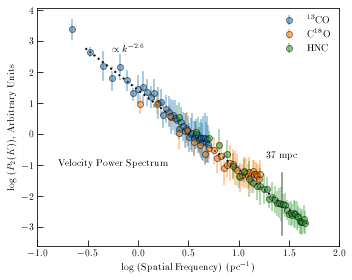

In [73]:
fig, ax = plt.subplots(figsize=(5, 4))
plot_powerspectrum(ax, soln_log_hnc_vc.x, spectrum='ps_vc', do_hnc=True)
fig.savefig('figs/NGC1333_Velocity_Power_Spectrum_Arb_fit_HNC_log.pdf', bbox_inches='tight')

### Intensity Power Spectrum

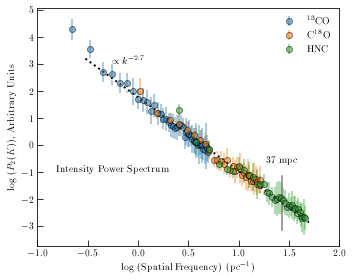

In [74]:
fig, ax = plt.subplots(figsize=(5, 4))
plot_powerspectrum(ax, soln_log_hnc.x, spectrum='ps_TdV', do_hnc=True)
fig.savefig('figs/NGC1333_Intensity_Power_Spectrum_Arb_fit_HNC_log.pdf', bbox_inches='tight')

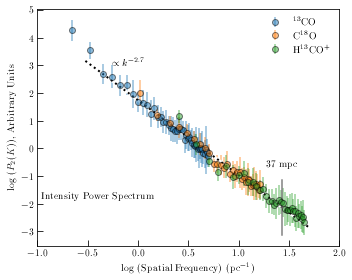

In [89]:
fig, ax = plt.subplots(figsize=(5, 4))
plot_powerspectrum(ax, soln_log_h13cop.x, spectrum='ps_TdV', do_hnc=False)
fig.savefig('figs/NGC1333_Intensity_Power_Spectrum_Arb_fit_H13COp_log.pdf', bbox_inches='tight')

### VCA

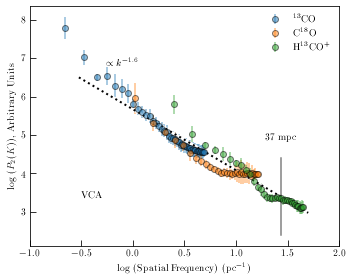

In [109]:
fig, ax = plt.subplots(figsize=(5, 4))
plot_powerspectrum(ax, soln_log_vca_h13cop.x, spectrum='ps_vca', do_hnc=False)
# ax.set_ylim(-3, 10)
# fig.savefig('figs/NGC1333_Intensity_Power_Spectrum_Arb_fit_H13COp_log.pdf', bbox_inches='tight')

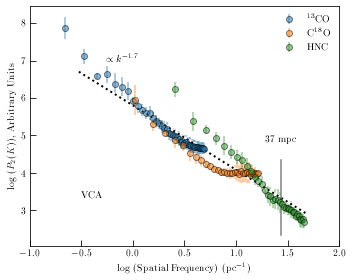

In [110]:
fig, ax = plt.subplots(figsize=(5, 4))
plot_powerspectrum(ax, soln_log_vca_hnc.x, spectrum='ps_vca', do_hnc=True)
# ax.set_ylim(-3, 10)
# fig.savefig('figs/NGC1333_Intensity_Power_Spectrum_Arb_fit_H13COp_log.pdf', bbox_inches='tight')

## EMCEE power-law fit
### Intensity for H$^{13}$CO$^+$

In [86]:
import emcee
import corner
from IPython.display import display, Math

pos = soln_log_h13cop.x + 1e-4 * np.random.randn(32, np.size(soln_log_h13cop.x))
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability_log_TdV_H13COp#, args=(x, y, yerr)
)
sampler.run_mcmc(pos, 5000, progress=True);

100%|███████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 618.35it/s]


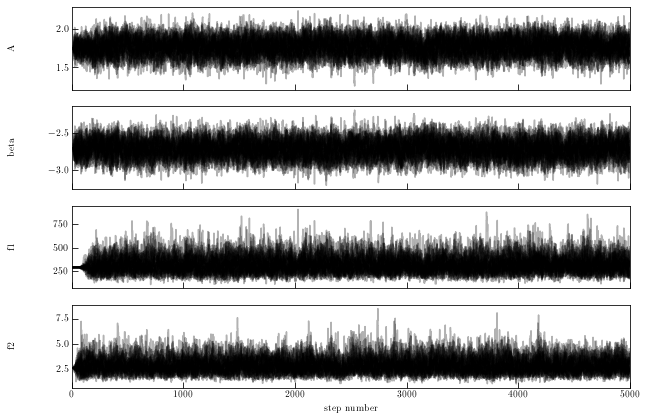

In [98]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["A", "beta", "f1", "f2"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [99]:
tau = sampler.get_autocorr_time()
print(tau)
flat_samples = sampler.get_chain(discard=300, thin=25, flat=True)

(6016, 4)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

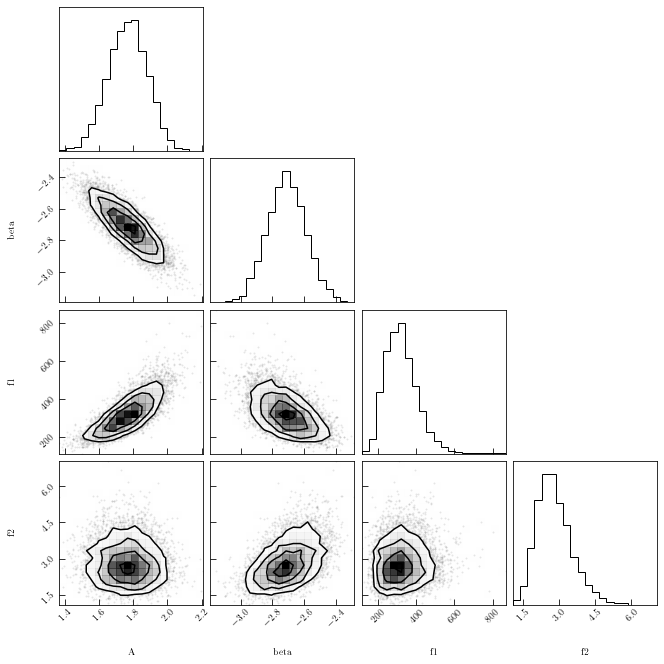

In [120]:
fig = corner.corner(
    flat_samples, labels=labels#, truths=[m_true, b_true, np.log(f_true)]
);

soln_log_h13cop_EMCEE = []
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.2f}_{{-{1:.2f}}}^{{{2:.2f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))
    soln_log_h13cop_EMCEE.append(mcmc[1])
    if i == 1:
        label_beta = r'$\propto k^{'
        label_beta = label_beta + '{0:.2f}_{{-{1:.2f}}}^{{{2:.2f}}}'.format(mcmc[1], q[0], q[1]) + '}$'


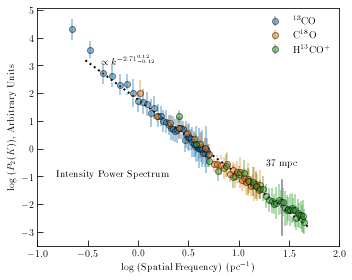

In [119]:
fig, ax = plt.subplots(figsize=(5, 4))
plot_powerspectrum(ax, soln_log_h13cop_EMCEE, ps_vc=False, do_hnc=False, label_power_fit=label_beta)
fig.savefig('figs/NGC1333_Intensity_Power_Spectrum_Arb_EMCEE_H13COp_log.pdf', bbox_inches='tight')

### Intensity for HNC

In [121]:
import emcee
import corner
from IPython.display import display, Math

pos_log_hnc = soln_log_hnc.x + 1e-4 * np.random.randn(32, np.size(soln_log_hnc.x))
nwalkers_log_hnc, ndim_log_hnc = pos_log_hnc.shape

sampler_log_hnc = emcee.EnsembleSampler(
    nwalkers_log_hnc, ndim_log_hnc, log_probability_log_TdV_HNC
)
sampler_log_hnc.run_mcmc(pos_log_hnc, 5000, progress=True);

100%|███████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:09<00:00, 535.83it/s]


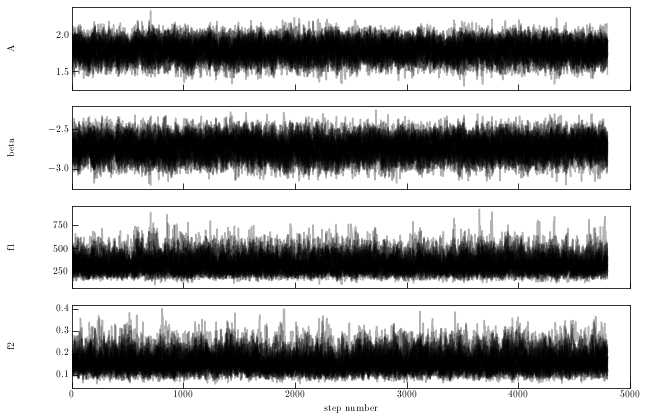

In [124]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples_log_hnc = sampler_log_hnc.get_chain()
labels = ["A", "beta", "f1", "f2"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples_log_hnc[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples_log_hnc))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [123]:
tau_log_hnc = sampler_log_hnc.get_autocorr_time()
print(tau_log_hnc)
flat_samples_log_hnc = sampler_log_hnc.get_chain(discard=300, thin=25, flat=True)

[42.95801693 48.49788213 46.99882042 53.9686179 ]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

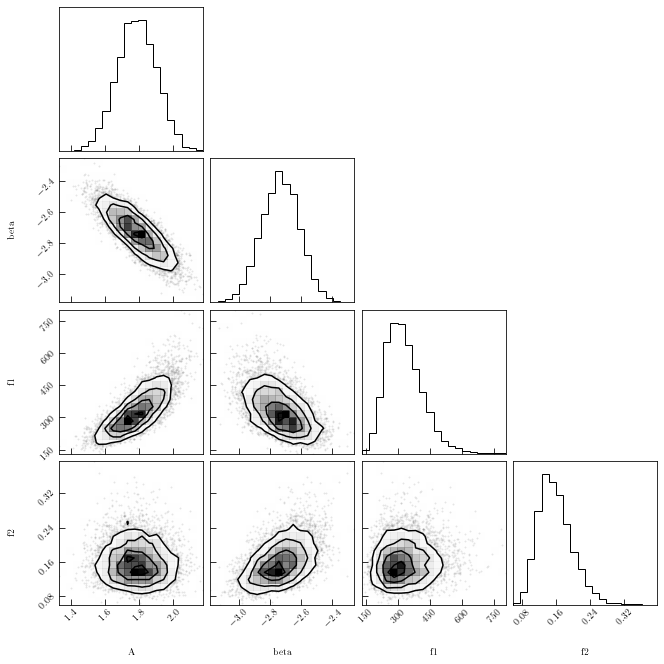

In [125]:
fig = corner.corner(
    flat_samples_log_hnc, labels=labels#, truths=[m_true, b_true, np.log(f_true)]
);

soln_log_hnc_EMCEE = []
for i in range(ndim):
    mcmc = np.percentile(flat_samples_log_hnc[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.2f}_{{-{1:.2f}}}^{{{2:.2f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))
    soln_log_hnc_EMCEE.append(mcmc[1])
    if i == 1:
        label_beta = r'$\propto k^{'
        label_beta = label_beta + '{0:.2f}_{{-{1:.2f}}}^{{{2:.2f}}}'.format(mcmc[1], q[0], q[1]) + '}$'


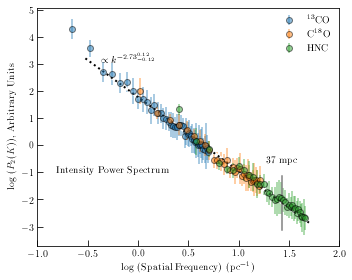

In [126]:
fig, ax = plt.subplots(figsize=(5, 4))
plot_powerspectrum(ax, soln_log_hnc_EMCEE, ps_vc=False, do_hnc=True, label_power_fit=label_beta)
fig.savefig('figs/NGC1333_Intensity_Power_Spectrum_Arb_EMCEE_HNC_log.pdf', bbox_inches='tight')

### Velocity for H$^{13}$CO$^+$

In [136]:
import emcee
import corner
from IPython.display import display, Math

pos_log_h13cop_vc = soln_log_h13cop_vc.x + 1e-4 * np.random.randn(32, np.size(soln_log_h13cop_vc.x))
nwalkers_log_h13cop_vc, ndim_log_h13cop_vc = pos_log_h13cop_vc.shape

sampler_log_h13cop_vc = emcee.EnsembleSampler(
    nwalkers_log_h13cop_vc, ndim_log_h13cop_vc, log_probability_log_vc_H13COp#, args=(x, y, yerr)
)
sampler_log_h13cop_vc.run_mcmc(pos_log_h13cop_vc, 5000, progress=True);

100%|███████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 564.01it/s]


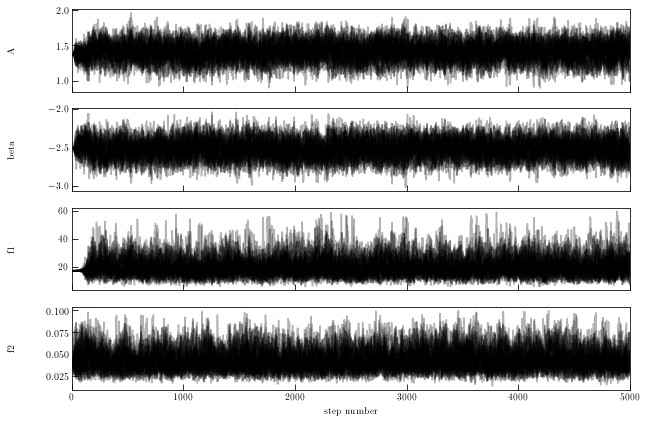

In [140]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples_log_h13cop_vc = sampler_log_h13cop_vc.get_chain()
labels = ["A", "beta", "f1", "f2"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples_log_h13cop_vc[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples_log_h13cop_vc))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [141]:
tau_log_h13cop_vc = sampler_log_h13cop_vc.get_autocorr_time()
print(tau_log_h13cop_vc)
flat_samples_log_h13cop_vc = sampler_log_h13cop_vc.get_chain(discard=300, thin=25, flat=True)

[47.59281213 48.38109126 48.31723933 52.04358489]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

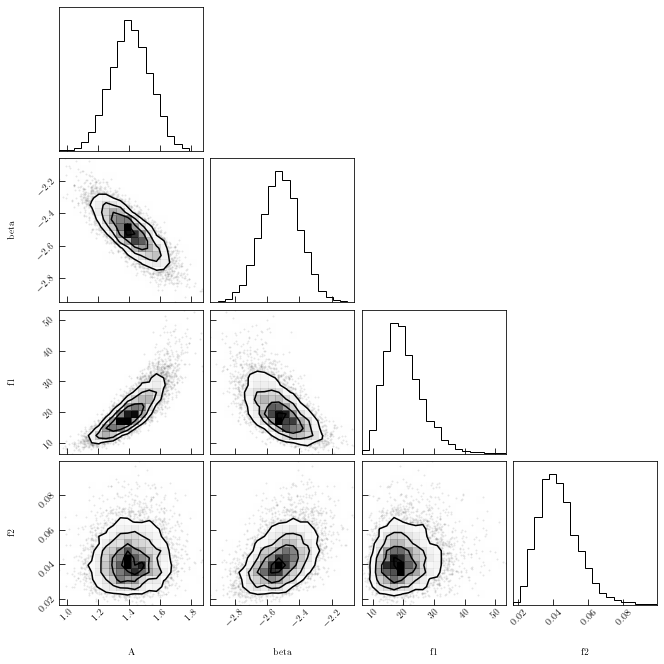

In [143]:
fig = corner.corner(
    flat_samples_log_h13cop_vc, labels=labels#, truths=[m_true, b_true, np.log(f_true)]
);

soln_log_h13cop_vc_EMCEE = []
for i in range(ndim):
    mcmc = np.percentile(flat_samples_log_h13cop_vc[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.2f}_{{-{1:.2f}}}^{{{2:.2f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))
    soln_log_h13cop_vc_EMCEE.append(mcmc[1])
    if i == 1:
        label_beta = r'$\propto k^{'
        label_beta = label_beta + '{0:.2f}_{{-{1:.2f}}}^{{{2:.2f}}}'.format(mcmc[1], q[0], q[1]) + '}$'


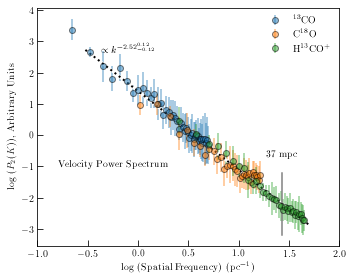

In [144]:
fig, ax = plt.subplots(figsize=(5, 4))
plot_powerspectrum(ax, soln_log_h13cop_vc_EMCEE, ps_vc=True, do_hnc=False, label_power_fit=label_beta)
fig.savefig('figs/NGC1333_Intensity_Power_Spectrum_Arb_EMCEE_H13COp_log_vc.pdf', bbox_inches='tight')

### Velocity for HNC

In [151]:
pos_log_hnc_vc = soln_log_hnc_vc.x + 1e-4 * np.random.randn(32, np.size(soln_log_hnc_vc.x))
nwalkers_log_hnc_vc, ndim_log_hnc_vc = pos_log_hnc_vc.shape

sampler_log_hnc_vc = emcee.EnsembleSampler(
    nwalkers_log_hnc_vc, ndim_log_hnc_vc, log_probability_log_vc_HNC#, args=(x, y, yerr)
)
sampler_log_hnc_vc.run_mcmc(pos_log_hnc_vc, 5000, progress=True);

100%|███████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 568.25it/s]


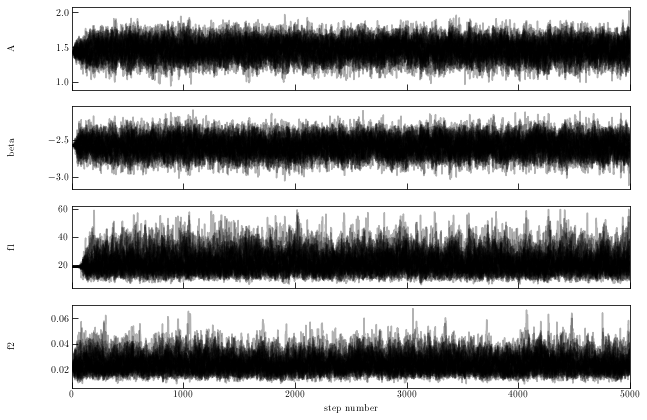

In [152]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples_log_hnc_vc = sampler_log_hnc_vc.get_chain()
labels = ["A", "beta", "f1", "f2"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples_log_hnc_vc[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples_log_hnc_vc))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [153]:
tau_log_hnc_vc = sampler_log_hnc_vc.get_autocorr_time()
print(tau_log_hnc_vc)
flat_samples_log_hnc_vc = sampler_log_hnc_vc.get_chain(discard=300, thin=25, flat=True)

[56.58344274 50.37711555 58.84826498 48.18877004]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

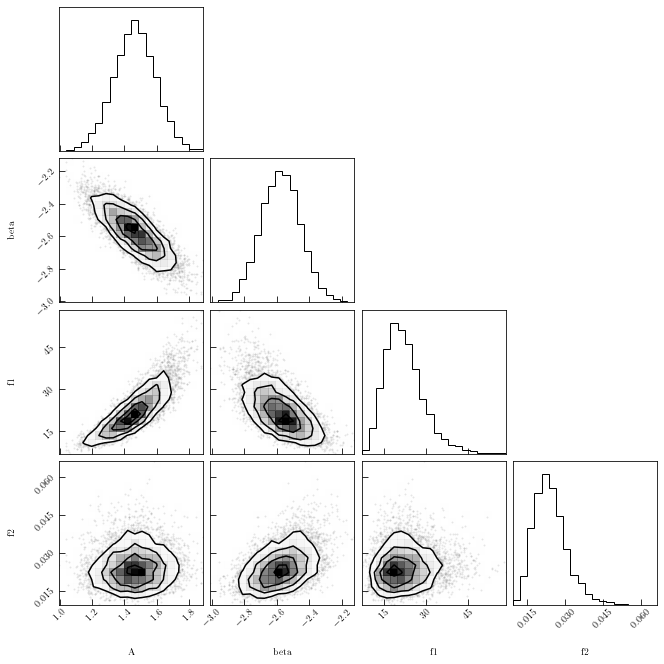

In [156]:
fig = corner.corner(
    flat_samples_log_hnc_vc, labels=labels#, truths=[m_true, b_true, np.log(f_true)]
);

soln_log_hnc_vc_EMCEE = []
for i in range(ndim):
    mcmc = np.percentile(flat_samples_log_hnc_vc[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.2f}_{{-{1:.2f}}}^{{{2:.2f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))
    soln_log_hnc_vc_EMCEE.append(mcmc[1])
    if i == 1:
        label_beta = r'$\propto k^{'
        label_beta = label_beta + '{0:.2f}_{{-{1:.2f}}}^{{{2:.2f}}}'.format(mcmc[1], q[0], q[1]) + '}$'


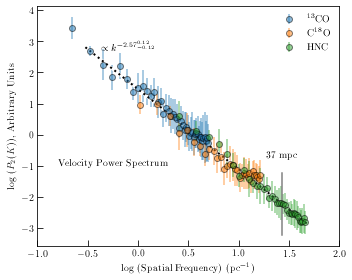

In [157]:
fig, ax = plt.subplots(figsize=(5, 4))
plot_powerspectrum(ax, soln_log_hnc_vc_EMCEE, ps_vc=True, do_hnc=True, label_power_fit=label_beta)
fig.savefig('figs/NGC1333_Intensity_Power_Spectrum_Arb_EMCEE_HNC_log_vc.pdf', bbox_inches='tight')